In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Data

In [2]:
raw_data = pd.read_csv("../raw_data/articles1.csv").sample(frac = 0.01)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 43063 to 17609
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   500 non-null    int64  
 1   id           500 non-null    int64  
 2   title        500 non-null    object 
 3   publication  500 non-null    object 
 4   author       444 non-null    object 
 5   date         500 non-null    object 
 6   year         500 non-null    float64
 7   month        500 non-null    float64
 8   url          0 non-null      float64
 9   content      500 non-null    object 
dtypes: float64(3), int64(2), object(5)
memory usage: 43.0+ KB


In [3]:
from big_picture.clusters import kmeans
from big_picture.vectorizers import tf_idf

vectors = tf_idf(raw_data.content)
clusters,sizes = kmeans(raw_data,'content',vectors,clusters=20, return_cluster_sizes=True)
sizes

,topic,Size
10,10,127
3,3,99
11,11,92
2,2,40
6,6,39
0,0,29
18,18,15
9,9,10
13,13,7
5,5,6


In [1]:
from big_picture.clusters import *

In [3]:
vectors = tf_idf(raw_data.content)
clusters = hdbscan(raw_data,'content',vectors,min_cluster_size=3)

In [5]:
clusters[0].topic

['hiv',
 'couples',
 'relationships',
 'manage',
 'relationship',
 'protective',
 'men',
 'messaging',
 'partner',
 'sex']

In [8]:
raw_content = raw_data.content
raw_content.head()

1611     A freight train slammed into a charter bus ful...
32319     (CNN) White House press secretary Sean Spicer...
1987     WASHINGTON  —   Senate Democrats on Thursday v...
22111    Super Saturday was a disaster for Marco Rubio ...
34837    Riyadh, Saudi Arabia (CNN) With his address in...
Name: content, dtype: object

# TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = raw_content

tf_idf_vectorizer = TfidfVectorizer()

X = tf_idf_vectorizer.fit_transform(texts)
X

NameError: name 'raw_content' is not defined

In [11]:
from sklearn.cluster import KMeans

tf_idf_model = KMeans(n_clusters=10).fit(X)

In [12]:
tf_idf_model.cluster_centers_.shape

(10, 21341)

In [16]:
topics = {}
for i, topic in enumerate(tf_idf_model.cluster_centers_):
        topics[i] = [tf_idf_vectorizer.get_feature_names()[i]
                        for i in topic.argsort()[:-10 - 1:-1]]

In [17]:
topics

{0: ['the',
  'milo',
  'to',
  'event',
  'of',
  'university',
  'students',
  'security',
  'berkeley',
  'fees'],
 1: ['the', 'to', 'and', 'of', 'in', 'that', 'on', 'you', 'is', 'it'],
 2: ['the',
  'of',
  'to',
  'in',
  'and',
  'syrian',
  'israeli',
  'syria',
  'forces',
  'isis'],
 3: ['the', 'she', 'her', 'to', 'and', 'in', 'of', 'women', 'was', 'that'],
 4: ['the', 'to', 'of', 'and', 'in', 'that', 'for', 'on', 'is', 'he'],
 5: ['the',
  'cosby',
  'of',
  'to',
  'sexual',
  'that',
  'and',
  'assault',
  'was',
  'ailes'],
 6: ['the',
  'clinton',
  'sanders',
  'to',
  'her',
  'of',
  'in',
  'and',
  'she',
  'mrs'],
 7: ['the', 'trump', 'to', 'of', 'mr', 'and', 'that', 'in', 'he', 'his'],
 8: ['cruz', 'the', 'rubio', 'trump', 'to', 'of', 'he', 'and', 'in', 'that'],
 9: ['the',
  'korea',
  'north',
  'korean',
  'to',
  'nuclear',
  'of',
  'kim',
  'missile',
  'russian']}

In [19]:
raw_data['topic'] = tf_idf_model.labels_
raw_data.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,topic
1611,1611,19090,At Least 4 Killed as Train Barrels Into Charte...,New York Times,Matthew Haag,2017-03-08,2017.0,3.0,NaN,A freight train slammed into a charter bus ful...,4
32319,32455,51222,Spicer slams ’nitpicking’ of Holocaust statement,CNN,Eric Bradner,2017-01-30,2017.0,1.0,NaN,(CNN) White House press secretary Sean Spicer...,7
1987,1987,19516,Democrats Plan to Filibuster to Thwart Gorsuch...,New York Times,"Matt Flegenheimer, Charlie Savage and Adam Liptak",2017-03-24,2017.0,3.0,NaN,WASHINGTON — Senate Democrats on Thursday v...,4
22111,22114,40861,The Theory of President Marco Rubio Breaks Aga...,Breitbart,Mike Flynn,2016-03-06,2016.0,3.0,NaN,Super Saturday was a disaster for Marco Rubio ...,8
34837,35530,54351,Trump’s speech to Muslim world a tough sell,CNN,Nic Robertson,2017-05-21,2017.0,5.0,NaN,"Riyadh, Saudi Arabia (CNN) With his address in...",7


In [22]:
X = raw_data
docs_per_topic = X.groupby(['topic'], as_index = False).agg({'content': ' '.join})
docs_per_topic

,topic,content
0,0,Students at George Washington University in Wa...
1,1,GOP frontrunner Donald Trump says the public s...
2,2,Istanbul (CNN) Syria was living Friday throug...
3,3,"(CNN) Billed as the grudge match of the year,..."
4,4,A freight train slammed into a charter bus ful...
5,5,(CNN) Celebrities took to social media‪ Satur...
6,6,On Friday’s broadcast of PBS’ “Washington Week...
7,7,(CNN) White House press secretary Sean Spicer...
8,8,Super Saturday was a disaster for Marco Rubio ...
9,9,(CNN) For the second time in a month a Russia...


In [26]:
result = tf_idf_vectorizer.fit_transform(docs_per_topic)
result

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [203]:
output[0]

(       Unnamed: 0     id                                              title  \
 23555       23559  42310  Revealed: Brando’s "Insatiable Sexual Appetite...   
 20220       20223  38969  Palestinian Teenager Arrested Carrying Knife i...   
 7420         7420  26020     Yes! Foods may fight acne - The New York Times   
 14735       14736  33472  Starbucks CEO Howard Schultz to Step Down in A...   
 11001       11001  29737  VIDEO: Fight Breaks Out on Southwest Airlines ...   
 2201         2201  19741  Trump University Suit Settlement Approved by J...   
 7124         7124  25636  Democrats and Feds in Dispute on Trump’s D.C. ...   
 40897       42885  61831  Detroit Police find bodies of two children in ...   
 16691       16692  35429             Texas Lights Up Blue to Support Police   
 28906       28914  47676  Trump to ’Free NASA’ and Set Sights on Further...   
 36823       37837  56678             Rebel coalition breaks siege of Aleppo   
 
           publication                

In [150]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model):
        print("Topic %d:" % (idx))
        print([vectorizer.get_feature_names()[i]
                        for i in topic.argsort()[:-10 - 1:-1]])
        print(model)
        break
        

print_topics(tf_idf_model.cluster_centers_, tf_idf_vectorizer)

Topic 0:
['brando', 'moreno', 'the', 'romance', 'she', 'oscar', 'her', 'tried', 'to', 'desire']
0


In [33]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=20).fit(X)

print_topics(lda_model.components_, tf_idf_vectorizer)

In [36]:
lda_model.transform(X[0])

array([[0.0034004 , 0.0034004 , 0.0034004 , 0.0034004 , 0.5353657 ,
        0.0034004 , 0.0034004 , 0.0034004 , 0.0034004 , 0.0034004 ,
        0.0034004 , 0.20329059, 0.0034004 , 0.0034004 , 0.07443649,
        0.0034004 , 0.13250081, 0.0034004 , 0.0034004 , 0.0034004 ]])

In [135]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

text_list = [text_to_word_sequence(sentence) for sentence in texts]

# Deep Learning

In [148]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=text_list, vector_size=10)

word2vec.wv["tesla"]

array([ 0.2100628 ,  0.1537489 ,  0.87903917, -0.5523931 , -0.07621907,
       -0.07617197,  0.4168468 ,  0.9264497 , -0.6768583 , -0.920836  ],
      dtype=float32)

In [151]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence.split(" "))
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_embed = embedding(word2vec, texts)


# Pad the training and test embedded sentences
shape_output = max([array.size for array in X_embed])
#X = pad_sequences(X_embed, dtype='float32', padding='post', maxlen=shape_output).reshape(1000,shape_output*10)

In [ ]:
X.shape

In [143]:
from scipy.sparse import csr_matrix

X = csr_matrix(X)

In [149]:
word2vec.wv.most_similar("trump")

[('clinton', 0.8887618780136108),
 ('trump’s', 0.8878629207611084),
 ('election', 0.8647207617759705),
 ('cruz', 0.8619100451469421),
 ('obama', 0.8521750569343567),
 ('ryan', 0.8442927598953247),
 ('candidate', 0.8231729865074158),
 ('unimatrixzeroone', 0.8141018152236938),
 ('’a', 0.8074794411659241),
 ('marc', 0.807149350643158)]

In [120]:
tf_idf_model = KMeans(n_clusters=20).fit(X)

for idx, topic in enumerate(tf_idf_model.cluster_centers_):
    print("Topic %d:" % (idx))
    print([word2vec.wv.most_similar(positive=[topic[i]], topn=1)
                    for i in topic.argsort()[:-10 - 1:-1]])

Topic 0:


TypeError: 'numpy.float32' object is not iterable

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

X

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']


<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

## Bert

In [75]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(raw_content.tolist(), show_progress_bar=True)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [76]:
embeddings.shape

(5000, 768)

In [2]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

NameError: name 'embeddings' is not defined

In [78]:
umap_embeddings.shape

(5000, 5)

In [106]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=3,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

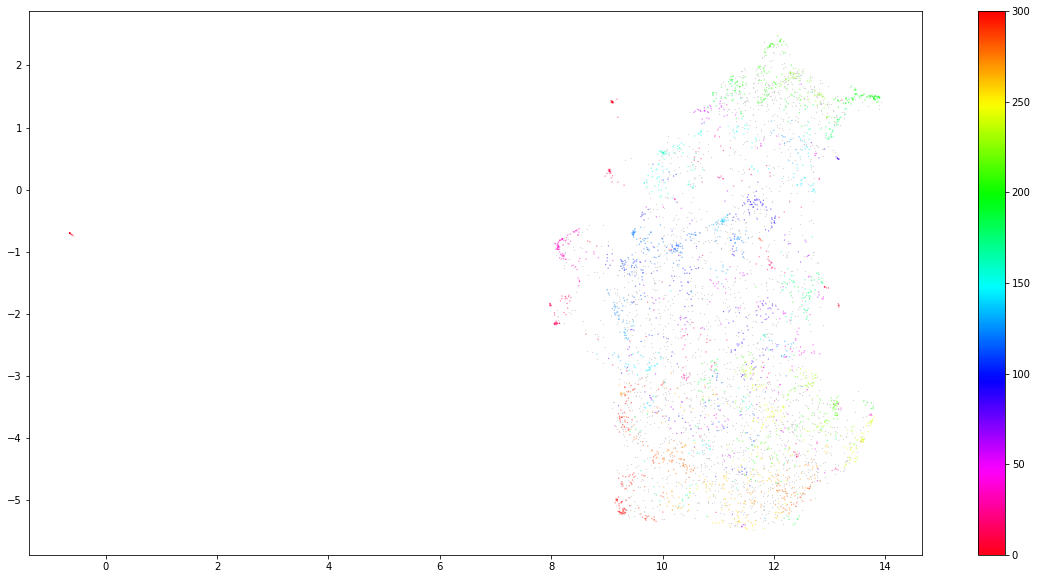

In [107]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [108]:
docs_df = pd.DataFrame(raw_content)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'content': ' '.join})

In [138]:
for article in docs_df[docs_df.Topic==97].content:
    print(article[:500])
    print("_________")

Law enforcement officials told CNN on Friday that, “barring new information that changes what they know,” charges will not be recommended against former National Security Adviser Michael Flynn over his telephone conversations with Russian Ambassador Sergey Kislyak. [Michael Flynn’s   calls to Kislyak became a controversy that ultimately resulted in his resignation, but even the final wave of media reports in the onslaught against him conceded that no illegal behavior occurred in the selected por
_________
Washington (CNN) There is ”absolutely not” any illness in Hillary Clinton’s medical records that hasn’t been disclosed, her campaign manager said Monday. Robby Mook told CNN’s Jake Tapper it was the fault of Clinton’s staff that the press wasn’t told for 90 minutes where the former secretary of state had gone when she left a   commemoration ceremony early after ”overheating” and having to be helped into a van after faltering Sunday. ”I wish we’d done that in a shorter amount of time. 

In [110]:
docs_per_topic

,Topic,content
0,-1,CAIRO — Unidentified gunmen sprayed bullets...
1,0,(CNN) Here’s a look at the life of Donald Tru...
2,1,advertisement advertisement advertisement adve...
3,2,’’ ’’ ’’ ’’ ’’ ’’ ’The business is. ..’ ad...
4,3,’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ’ ...
...,...,...
297,296,"In fairness, we Trump supporters don’t want to..."
298,297,(CNN) National security analyst KT McFarland ...
299,298,(CNN) Former President Barack Obama made his ...
300,299,Ted Cruz wrapped up the remaining 13 Colorado ...


In [27]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.content.values, m=len(raw_content))

In [32]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .content
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "content": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(raw_data); topic_sizes.head(10)

,topic,Size
4,4,222
1,1,105
7,7,65
3,3,32
6,6,20
8,8,16
2,2,12
5,5,11
9,9,10
0,0,7


In [34]:
top_n_words

{0: [('berkeley', 0.03790399436411166),
  ('milo', 0.03452270839997035),
  ('bcr', 0.033793136490376435),
  ('event', 0.03329955344309578),
  ('fees', 0.02497548359914517),
  ('university', 0.022554546991616724),
  ('college', 0.021830192099443445),
  ('students', 0.020191842585142967),
  ('campus', 0.017824492909852857),
  ('uc', 0.017671651951890414),
  ('fee', 0.01575088543160305),
  ('sponsors', 0.01575088543160305),
  ('dirks', 0.01375587959345385),
  ('security', 0.013593313738962897),
  ('kew', 0.012161532619278858),
  ('ben_kew', 0.012161532619278858),
  ('free', 0.01166768553685739),
  ('riots', 0.011445537097111033),
  ('letter', 0.011243970769085822),
  ('ucpd', 0.010931614978107015)],
 1: [('14', 0.00722446293500642),
  ('june', 0.006985449843423584),
  ('pm', 0.006879888484055263),
  ('orlando', 0.006584593711736108),
  ('mateen', 0.006524528353843606),
  ('https', 0.005162131461129256),
  ('facebook', 0.004713970498174715),
  ('pic', 0.004448411815540205),
  ('tire', 0.00

In [33]:
top_n_words[4][:20]

[('percent', 0.0018116570318634458),
 ('county', 0.0015986283591347642),
 ('nawaz', 0.0015772950767711533),
 ('sears', 0.0015721861088093198),
 ('data', 0.0015691838343167568),
 ('court', 0.0015225197164713802),
 ('health', 0.0015131218290820698),
 ('federal', 0.0014894642934859526),
 ('city', 0.0014858443013278455),
 ('illegal', 0.0014857448712542773),
 ('number', 0.0014655663314912402),
 ('lampert', 0.0014646903112624312),
 ('program', 0.0014424900801543981),
 ('officers', 0.0014299622763316428),
 ('refugees', 0.0014225374374273478),
 ('food', 0.0014172689597827482),
 ('company', 0.0013735000891971231),
 ('border', 0.0013684871334817452),
 ('public', 0.0013604559054788013),
 ('government', 0.0013604233810189507)]

## Kmeans

In [129]:
from sklearn.cluster import KMeans

bert_kmean_model = KMeans(n_clusters=400).fit(umap_embeddings)

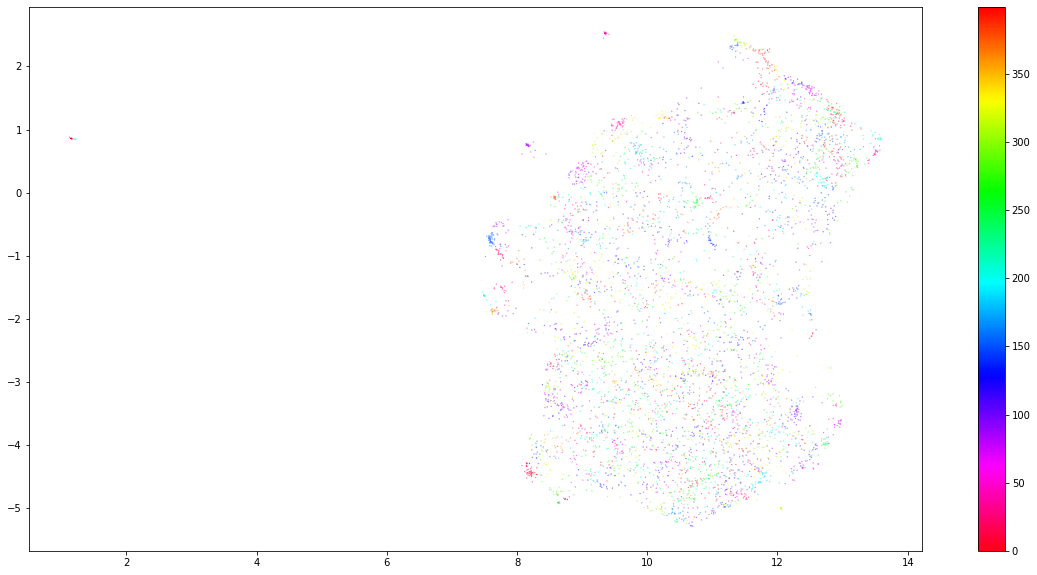

In [130]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = bert_kmean_model.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [131]:
docs_df = pd.DataFrame(raw_content)
docs_df['Topic'] = bert_kmean_model.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'content': ' '.join})

,content,Topic,Doc_ID
2713,CAIRO — Unidentified gunmen sprayed bullets...,58,0
22146,"On December 20, the BBC pointed out that the “...",236,1
17282,A new poll released by Maine People’s Resource...,12,2
6447,WASHINGTON — Donald J. Trump on Wednesday...,271,3
24136,Breitbart Tech editor Milo Yiannopoulos told B...,164,4
...,...,...,...
9481,Failed presidential candidate Hillary Clinton ...,272,4995
37766,(CNN) It was a attempt to show the disturbi...,262,4996
31219,"On Friday’s “PBS NewsHour,” New York Times col...",191,4997
45050,’ ’ ” Environmental Protection Agency Admin...,61,4998


# Word cloud

In [4]:
clusters[0].wordcloud

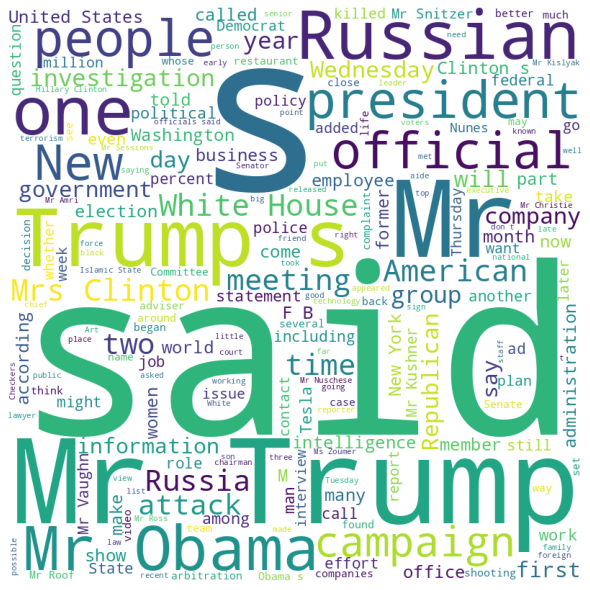

In [5]:
# Python program to generate WordCloud

# importing all necessery modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

	# typecaste 
# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(clusters[0].wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()
